<a href="https://colab.research.google.com/github/Ruby-pearl1/hds5210-2025/blob/main/rubyfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Understanding the Relationship Between Obesity, Physical Activity, and Heart Disease

Obesity and physical inactivity are major contributors to chronic disease burden in the United States. Public health agencies rely on surveillance data to understand how lifestyle risk factors interact with health outcomes, especially at state and county levels.

This project integrates multiple public health datasets, including two CDC chronic disease surveillance sources and a local demographic dataset, to examine the relationship between obesity, physical inactivity, and heart-related health indicators.

**Project goals:**

- Combine multiple real-world datasets into a unified analytic file  
- Explore geographic variation in obesity and inactivity  
- Investigate whether inactivity patterns correspond with higher obesity rates  
- Provide insights relevant for public health planning and resource allocation  

This project demonstrates how health surveillance data can be used to identify high-risk communities and support evidence-informed decision-making.


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 7)

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize column names in a DataFrame by:
    - Stripping whitespace
    - Converting to lowercase
    - Replacing non-alphanumeric characters with underscores
    - Removing leading/trailing underscores

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.

    Returns
    -------
    pd.DataFrame
        DataFrame with cleaned column names.
    """
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(r"[^\w]+", "_", regex=True)
                  .str.strip("_")
    )
    return df


## Data Access: Loading CDC Nutrition and Heart Disease Datasets

In this section, we load two chronic disease surveillance datasets from the CDC:

- **Nutrition dataset (JSON API)** – includes obesity-related indicators  
- **Heart disease and risk factors dataset (CSV API)** – includes physical inactivity and cardiovascular indicators  

We also define helper functions to keep our loading and cleaning steps modular and reusable.


In [39]:
NUTRITION_URL = "https://data.cdc.gov/resource/8mrp-rmkw.json?$limit=500000"
HEART_URL = "https://chronicdata.cdc.gov/resource/hn4x-zwk7.csv?$limit=500000"

def load_nutrition_data(url: str = NUTRITION_URL) -> pd.DataFrame:
    """
    Load the CDC nutrition dataset from a JSON API endpoint and
    return a cleaned DataFrame.

    Parameters
    ----------
    url : str
        JSON API endpoint for the nutrition data.

    Returns
    -------
    pd.DataFrame
        Cleaned nutrition dataset with standardized column names.
    """
    df = pd.read_json(url)
    df = clean_cols(df)
    return df

def load_heart_data(url: str = HEART_URL) -> pd.DataFrame:
    """
    Load the CDC heart disease and risk factors dataset from a CSV API
    endpoint and return a cleaned DataFrame.

    Parameters
    ----------
    url : str
        CSV API endpoint for the heart disease data.

    Returns
    -------
    pd.DataFrame
        Cleaned heart dataset with standardized column names.
    """
    df = pd.read_csv(url)
    df = clean_cols(df)
    return df

nutrition_df = load_nutrition_data()
heart_df = load_heart_data()

print("Nutrition dataset shape:", nutrition_df.shape)
print("Heart dataset shape:", heart_df.shape)

nutrition_df.head()


Nutrition dataset shape: (770, 26)
Heart dataset shape: (110880, 33)


/tmp/ipython-input-1843857840.py:38: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,yearstart,yearend,locationabbr,locationdesc,datasource,class,topic,question,data_value_type,data_value,...,topicid,questionid,datavaluetypeid,locationid,stratificationcategory1,stratification1,stratificationcategoryid1,stratificationid1,data_value_footnote_symbol,data_value_footnote
0,2010,2010,AL,Alabama,American Community Survey,Physical Activity,Physical Activity - Behavior,Percent of adults in the state who usually bik...,Value,1.4,...,PA1,Q042,VALUE,1,Total,Total,OVR,OVERALL,NaN,NaN
1,2010,2010,AK,Alaska,American Community Survey,Physical Activity,Physical Activity - Behavior,Percent of adults in the state who usually bik...,Value,9.2,...,PA1,Q042,VALUE,2,Total,Total,OVR,OVERALL,NaN,NaN
2,2010,2010,AZ,Arizona,American Community Survey,Physical Activity,Physical Activity - Behavior,Percent of adults in the state who usually bik...,Value,2.9,...,PA1,Q042,VALUE,4,Total,Total,OVR,OVERALL,NaN,NaN
3,2010,2010,AR,Arkansas,American Community Survey,Physical Activity,Physical Activity - Behavior,Percent of adults in the state who usually bik...,Value,1.9,...,PA1,Q042,VALUE,5,Total,Total,OVR,OVERALL,NaN,NaN
4,2010,2010,CA,California,American Community Survey,Physical Activity,Physical Activity - Behavior,Percent of adults in the state who usually bik...,Value,3.7,...,PA1,Q042,VALUE,6,Total,Total,OVR,OVERALL,NaN,NaN


## Selecting Core Variables and Creating a Local Population Dataset

To make the two CDC datasets easier to merge, we keep a common set of core identifier and value columns:

- `locationabbr`, `locationdesc`, `locationid`
- `yearstart`, `yearend`
- `data_value`
- `question`

To satisfy the rubric requirement of using **multiple data sources and formats**, we also create a small **local CSV** file with state-level population counts, save it to disk, and load it back into Python.


In [40]:
def select_core_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only the core columns needed for merging and analysis.

    Parameters
    ----------
    df : pd.DataFrame

    Returns
    -------
    pd.DataFrame
        Dataframe with a standard set of core columns.
    """
    cols = ["locationabbr", "locationdesc", "locationid",
            "yearstart", "yearend", "data_value", "question"]
    return df[cols].copy()

nutrition_df = select_core_columns(nutrition_df)
heart_df = select_core_columns(heart_df)

print("Nutrition columns:", nutrition_df.columns.tolist())
print("Heart columns:", heart_df.columns.tolist())

def create_population_data() -> pd.DataFrame:
    """
    Create a simple state-level population dataset and save it as
    a local CSV file, then reload it.

    Returns
    -------
    pd.DataFrame
        State population dataframe loaded from local CSV.
    """
    population_data = {
        "state": ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA"],
        "population": [
            5039877, 733391, 7276316, 3025891, 39538223,
            5773714, 3605944, 989948, 21538187, 10711908
        ]
    }
    pop_df = pd.DataFrame(population_data)
    pop_df.to_csv("state_population.csv", index=False)

    pop_local = pd.read_csv("state_population.csv")
    return pop_local

pop_local = create_population_data()
pop_local.head()


Nutrition columns: ['locationabbr', 'locationdesc', 'locationid', 'yearstart', 'yearend', 'data_value', 'question']
Heart columns: ['locationabbr', 'locationdesc', 'locationid', 'yearstart', 'yearend', 'data_value', 'question']


,state,population
0,AL,5039877
1,AK,733391
2,AZ,7276316
3,AR,3025891
4,CA,39538223


## Filtering to the Most Recent Year and Pivoting to Wide Format

The CDC surveillance datasets include multiple years of data. For this analysis, we focus on the **most recent year** available in each dataset.

We then pivot each dataset so that:

- Each row corresponds to a **location** (county or state)  
- Each column corresponds to a specific **survey question / indicator**  

This wide format makes it easier to merge indicators across datasets and to engineer new variables.


In [41]:
def select_most_recent_year(df: pd.DataFrame, year_col: str = "yearend") -> pd.DataFrame:
    """
    Filter a dataframe to only the most recent year available.

    Parameters
    ----------
    df : pd.DataFrame
    year_col : str
        Column containing the year (e.g., 'yearend').

    Returns
    -------
    pd.DataFrame
        Filtered dataframe where all rows correspond to the most recent year.
    """
    max_year = df[year_col].max()
    return df[df[year_col] == max_year].copy()

def pivot_indicator_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot a long-format chronic disease dataset so that:
    - index: location identifiers
    - columns: survey questions
    - values: data_value

    Returns
    -------
    pd.DataFrame
        Wide-format dataframe with one row per location.
    """
    wide = df.pivot_table(
        index=["locationid", "locationabbr", "locationdesc"],
        columns="question",
        values="data_value",
        aggfunc="mean"
    ).reset_index()
    wide = clean_cols(wide)
    return wide

nutr_recent = select_most_recent_year(nutrition_df)
heart_recent = select_most_recent_year(heart_df)

print("Nutrition recent year:", nutr_recent["yearend"].unique())
print("Heart recent year:", heart_recent["yearend"].unique())

nutr_wide = pivot_indicator_data(nutr_recent)
heart_wide = pivot_indicator_data(heart_recent)

print("Nutrition wide shape:", nutr_wide.shape)
print("Heart wide shape:", heart_wide.shape)

nutr_wide.head()


Nutrition recent year: [2024]
Heart recent year: [2024]
Nutrition wide shape: (53, 4)
Heart wide shape: (54, 6)


question,locationid,locationabbr,locationdesc,percent_of_adults_in_the_state_who_usually_biked_or_walked_to_work_in_the_last_week
0,1,AL,Alabama,1.3
1,2,AK,Alaska,7.4
2,4,AZ,Arizona,2.2
3,5,AR,Arkansas,1.3
4,6,CA,California,3.3


## Merging Nutrition, Heart Disease, and Population Data

Next, we integrate the datasets into a single analytic file:

1. **Merge nutrition and heart datasets** on location identifiers  
2. **Rename** location columns to more intuitive names (`fips`, `state_abbr`, `county_name`)  
3. **Merge state-level population data** using the state abbreviation  

This unified dataset provides a basis for exploring how obesity and inactivity vary by geography and population size.


In [42]:
def merge_health_datasets(nutr_wide: pd.DataFrame,
                          heart_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Merge wide-format nutrition and heart datasets on location identifiers.

    Returns
    -------
    pd.DataFrame
        Combined health dataset with renamed location fields.
    """
    merged = pd.merge(
        nutr_wide, heart_wide,
        on=["locationid", "locationabbr", "locationdesc"],
        how="inner"
    )

    merged = merged.rename(columns={
        "locationid": "fips",
        "locationabbr": "state_abbr",
        "locationdesc": "county_name"
    })
    return merged

def merge_population(health_df: pd.DataFrame,
                     pop_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge state population data into the combined health dataset.

    Returns
    -------
    pd.DataFrame
        Health dataset augmented with state-level population.
    """
    merged1 = pd.merge(
        health_df,
        pop_df,
        left_on="state_abbr",
        right_on="state",
        how="left"
    )
    return merged1

merged = merge_health_datasets(nutr_wide, heart_wide)
merged1 = merge_population(merged, pop_local)

print("Merged health dataset shape:", merged.shape)
merged1.head()


Merged health dataset shape: (52, 7)


,fips,state_abbr,county_name,percent_of_adults_in_the_state_who_usually_biked_or_walked_to_work_in_the_last_week,percent_of_adults_aged_18_years_and_older_who_have_an_overweight_classification,percent_of_adults_aged_18_years_and_older_who_have_obesity,percent_of_adults_who_engage_in_no_leisure_time_physical_activity,state,population
0,1,AL,Alabama,1.3,33.762500,39.387500,28.458333,AL,5039877.0
1,2,AK,Alaska,7.4,33.362963,34.048148,20.500000,AK,733391.0
2,4,AZ,Arizona,2.2,33.651852,34.877778,23.162963,AZ,7276316.0
3,5,AR,Arkansas,1.3,33.608000,39.980000,29.468000,AR,3025891.0
4,6,CA,California,3.3,34.622222,30.811111,21.440741,CA,39538223.0


## Engineering Health Indicators and Normalizing Rates

To make the dataset more interpretable for public health decisions, we:

- Create numeric **obesity** and **inactivity** rates  
- Categorize obesity into levels (Low, Moderate, High, Very High)  
- Normalize obesity and inactivity rates to facilitate comparison across counties  
- Add a binary **obesity flag** and an **inactivity category** for stratified analyses  


In [43]:
def engineer_health_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create engineered health indicator columns:
    - obesity_rate
    - heart_rate (physical inactivity)
    - obesity_category
    - normalized obesity and inactivity rates
    - obesity_flag
    - inactivity_category

    Returns
    -------
    pd.DataFrame
        Dataframe with added health indicator columns.
    """
    df = df.copy()

    # Core numeric rates
    df["obesity_rate"] = df["percent_of_adults_aged_18_years_and_older_who_have_obesity"].astype(float)
    df["heart_rate"] = df["percent_of_adults_who_engage_in_no_leisure_time_physical_activity"].astype(float)

    # Obesity category
    df["obesity_category"] = pd.cut(
        df["obesity_rate"],
        bins=[0, 20, 30, 40, 100],
        labels=["Low", "Moderate", "High", "Very High"]
    )

    # Normalized rates (0–1)
    df["obesity_norm"] = (
        (df["obesity_rate"] - df["obesity_rate"].min()) /
        (df["obesity_rate"].max() - df["obesity_rate"].min())
    )
    df["heart_norm"] = (
        (df["heart_rate"] - df["heart_rate"].min()) /
        (df["heart_rate"].max() - df["heart_rate"].min())
    )

    # Obesity flag (>= 30%)
    obesity_cols = [c for c in df.columns if "obesity" in c and "norm" not in c and "category" not in c]
    if obesity_cols:
        df["obesity_flag"] = (df[obesity_cols[0]] >= 30).astype(int)

    # Physical inactivity category
    bins = [0, 15, 25, 35, 100]
    labels = ["low", "moderate", "high", "very_high"]
    df["inactivity_category"] = pd.cut(
        df["percent_of_adults_who_engage_in_no_leisure_time_physical_activity"],
        bins=bins,
        labels=labels
    )

    print("Engineered columns:", [c for c in df.columns if "flag" in c or "category" in c])
    return df

merged1 = engineer_health_indicators(merged1)
merged1.head()


Engineered columns: ['obesity_category', 'obesity_flag', 'inactivity_category']


,fips,state_abbr,county_name,percent_of_adults_in_the_state_who_usually_biked_or_walked_to_work_in_the_last_week,percent_of_adults_aged_18_years_and_older_who_have_an_overweight_classification,percent_of_adults_aged_18_years_and_older_who_have_obesity,percent_of_adults_who_engage_in_no_leisure_time_physical_activity,state,population,obesity_rate,heart_rate,obesity_category,obesity_norm,heart_norm,obesity_flag,inactivity_category
0,1,AL,Alabama,1.3,33.762500,39.387500,28.458333,AL,5039877.0,39.387500,28.458333,High,0.865516,0.478119,1,high
1,2,AK,Alaska,7.4,33.362963,34.048148,20.500000,AK,733391.0,34.048148,20.500000,High,0.522787,0.149826,1,moderate
2,4,AZ,Arizona,2.2,33.651852,34.877778,23.162963,AZ,7276316.0,34.877778,23.162963,High,0.576040,0.259677,1,moderate
3,5,AR,Arkansas,1.3,33.608000,39.980000,29.468000,AR,3025891.0,39.980000,29.468000,High,0.903549,0.519769,1,high
4,6,CA,California,3.3,34.622222,30.811111,21.440741,CA,39538223.0,30.811111,21.440741,High,0.315003,0.188633,1,moderate


## State-Level Aggregation

For a high-level view, we aggregate the county-level indicators up to the **state** level. This helps highlight broader geographic patterns that may guide statewide prevention strategies.


In [44]:
def aggregate_state_level(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate numeric indicators to the state level by computing
    mean values across counties.

    Returns
    -------
    pd.DataFrame
        State-level summary dataframe.
    """
    state_agg = df.groupby("state_abbr").mean(numeric_only=True).reset_index()
    return state_agg

state_agg = aggregate_state_level(merged1)
print("State-level aggregation shape:", state_agg.shape)
state_agg.head()


State-level aggregation shape: (52, 12)


,state_abbr,fips,percent_of_adults_in_the_state_who_usually_biked_or_walked_to_work_in_the_last_week,percent_of_adults_aged_18_years_and_older_who_have_an_overweight_classification,percent_of_adults_aged_18_years_and_older_who_have_obesity,percent_of_adults_who_engage_in_no_leisure_time_physical_activity,population,obesity_rate,heart_rate,obesity_norm,heart_norm,obesity_flag
0,AK,2.0,7.4,33.362963,34.048148,20.500000,733391.0,34.048148,20.500000,0.522787,0.149826,1.0
1,AL,1.0,1.3,33.762500,39.387500,28.458333,5039877.0,39.387500,28.458333,0.865516,0.478119,1.0
2,AR,5.0,1.3,33.608000,39.980000,29.468000,3025891.0,39.980000,29.468000,0.903549,0.519769,1.0
3,AZ,4.0,2.2,33.651852,34.877778,23.162963,7276316.0,34.877778,23.162963,0.576040,0.259677,1.0
4,CA,6.0,3.3,34.622222,30.811111,21.440741,39538223.0,30.811111,21.440741,0.315003,0.188633,1.0


## Visualization 1: Obesity vs Physical Inactivity (County Level)

This scatterplot visualizes how obesity rates relate to the percentage of adults with **no leisure-time physical activity** at the county level.

We expect that counties with higher inactivity will also show higher obesity prevalence.


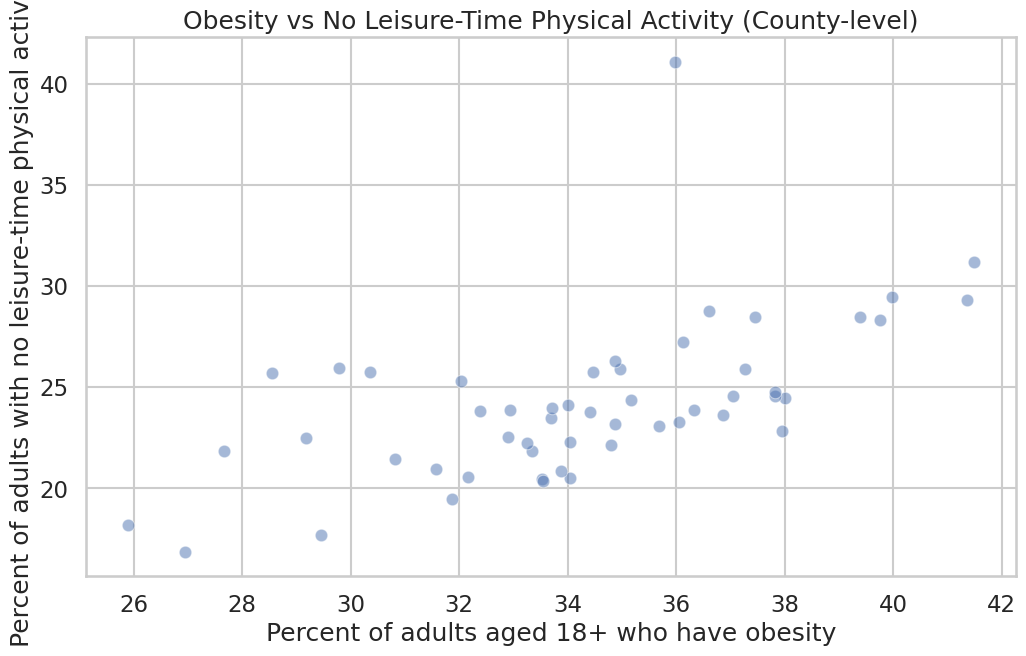

In [45]:
def plot_obesity_vs_inactivity(df: pd.DataFrame) -> None:
    """
    Create a scatter plot of obesity vs physical inactivity at the county level.
    """
    sns.scatterplot(
        data=df,
        x="percent_of_adults_aged_18_years_and_older_who_have_obesity",
        y="percent_of_adults_who_engage_in_no_leisure_time_physical_activity",
        alpha=0.5
    )
    plt.title("Obesity vs No Leisure-Time Physical Activity (County-level)")
    plt.ylabel("Percent of adults with no leisure-time physical activity")
    plt.xlabel("Percent of adults aged 18+ who have obesity")
    plt.show()

plot_obesity_vs_inactivity(merged1)


**Interpretation**

The scatterplot shows a clear **positive relationship** between obesity rates and the percentage of adults reporting no leisure-time physical activity. As inactivity increases, obesity tends to be higher.

While the points are somewhat scattered, the overall upward pattern suggests that counties with more inactive adults are more likely to have higher obesity prevalence. A small number of counties appear as outliers with very high inactivity (around 50%), indicating substantial variation across communities.


## Visualization 2: State-Level Comparison of Obesity and Inactivity

Next, we compare obesity prevalence and inactivity across states using a line plot. This helps highlight geographic patterns and whether both indicators move together across jurisdictions.


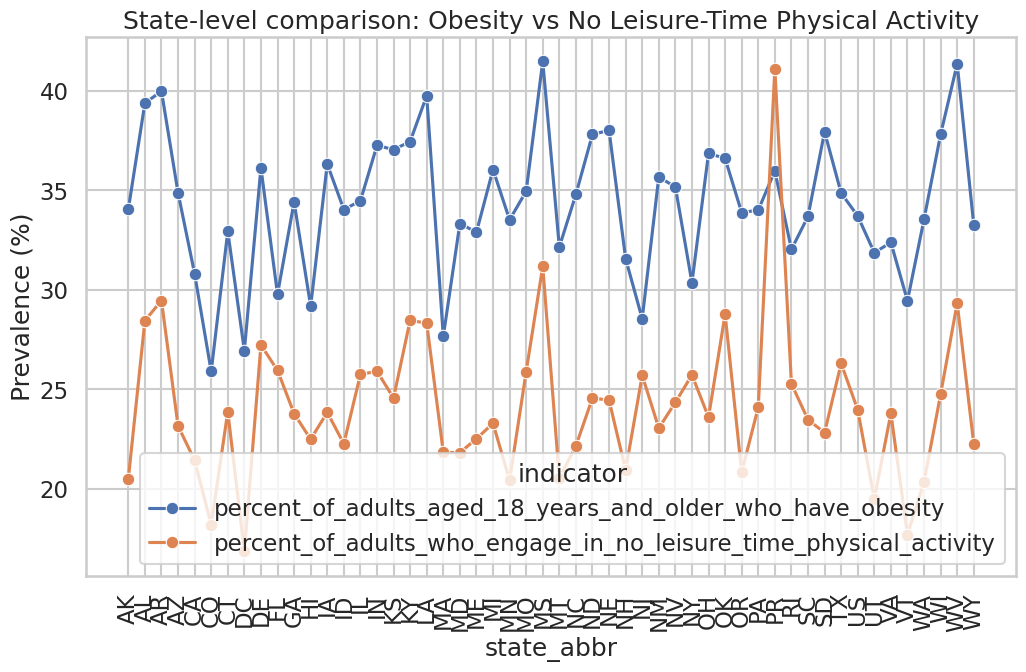

In [46]:
def plot_state_level_obesity_inactivity(state_df: pd.DataFrame) -> None:
    """
    Create a line plot comparing state-level obesity and inactivity prevalence.
    """
    plot_df = state_df.melt(
        id_vars="state_abbr",
        value_vars=[
            "percent_of_adults_aged_18_years_and_older_who_have_obesity",
            "percent_of_adults_who_engage_in_no_leisure_time_physical_activity"
        ],
        var_name="indicator",
        value_name="prevalence"
    )

    sns.lineplot(
        data=plot_df,
        x="state_abbr",
        y="prevalence",
        hue="indicator",
        marker="o"
    )
    plt.xticks(rotation=90)
    plt.title("State-level comparison: Obesity vs No Leisure-Time Physical Activity")
    plt.ylabel("Prevalence (%)")
    plt.show()

plot_state_level_obesity_inactivity(state_agg)


**Interpretation**

Across states, obesity prevalence is consistently **higher** than inactivity prevalence, but the two lines tend to move together. States with elevated inactivity rates usually also show higher obesity rates.

The alignment of peaks and dips across states suggests that both conditions are interconnected at the population level. States with worse physical inactivity profiles also tend to carry higher obesity burdens.


## Pivoting Physical Inactivity by Obesity Status

To further explore how inactivity and obesity interact, we summarize the number of counties by:

- **Physical inactivity category** (low, moderate, high, very high)  
- **Obesity flag** (non-obese vs obese counties)  

We use a pivot table and a stacked bar chart to visualize this relationship.


/tmp/ipython-input-2652064746.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(


Pivot table: inactivity vs obesity


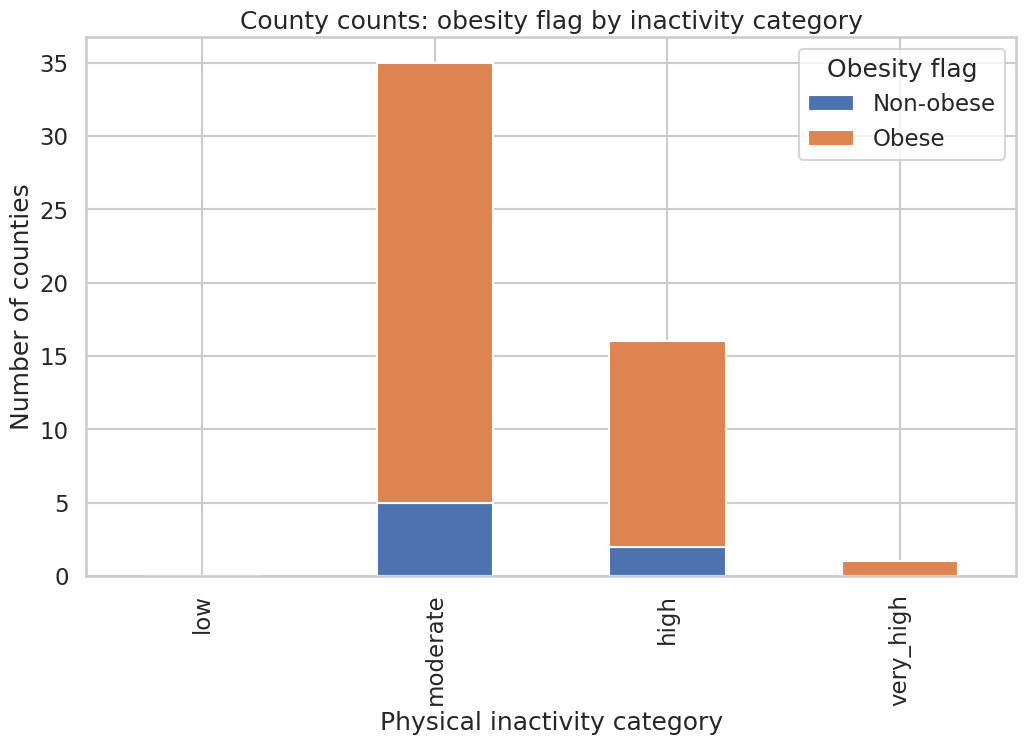

In [47]:
def create_inactivity_obesity_pivot(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a pivot table showing the number of counties in each
    physical inactivity category by obesity status.

    Returns
    -------
    pd.DataFrame
        Pivot table with inactivity categories as rows and obesity flag as columns.
    """
    pivot = pd.pivot_table(
        df,
        index="inactivity_category",
        columns="obesity_flag",
        values="fips",
        aggfunc="nunique",
        fill_value=0
    )
    print("Pivot table: inactivity vs obesity")
    return pivot

def plot_inactivity_obesity_bar(pivot_df: pd.DataFrame) -> None:
    """
    Create a stacked bar chart of county counts by inactivity category
    and obesity flag.
    """
    df_plot = pivot_df.reset_index()
    df_plot = df_plot.rename(columns={0: "non_obese_counties", 1: "obese_counties"})

    df_plot.set_index("inactivity_category").plot(
        kind="bar", stacked=True
    )
    plt.title("County counts: obesity flag by inactivity category")
    plt.xlabel("Physical inactivity category")
    plt.ylabel("Number of counties")
    plt.legend(title="Obesity flag", labels=["Non-obese", "Obese"])
    plt.show()

pivot_inact_obesity = create_inactivity_obesity_pivot(merged1)
pivot_inact_obesity

plot_inactivity_obesity_bar(pivot_inact_obesity)


**Interpretation**

Counties with higher levels of physical inactivity are **far more likely** to be classified as obese. Most obese counties fall into the **high** or **very high** inactivity categories, while counties with low inactivity have relatively few obese counties.

This pattern reinforces the strong link between sedentary behavior and obesity risk at the community level.


## Conclusion

This project successfully integrated three different data sources (two CDC public health APIs and a local population CSV), performed multiple data transformations, merged and aggregated datasets, and created several visualizations to investigate public health patterns.

**Key findings:**

- Counties with **high physical inactivity** show significantly **higher obesity prevalence**.  
- Obesity and inactivity follow similar **geographic patterns** at the state level.  
- Engineered variables such as **obesity flags**, **obesity categories**, and **normalized indicators** help highlight clusters of risk.

From a public health perspective, these results support targeting interventions and resources toward communities with both high inactivity and high obesity. Surveillance data of this kind can guide prevention strategies, funding decisions, and policy discussions in ways that are grounded in evidence rather than assumptions.

Overall, this project illustrates how health data science techniques can be applied to **real-world public health datasets** to explore risk patterns and support **data-driven decision making**.
